### Predict Future Sales:
#### Final project for "How to win a data science competition" Coursera course
###### https://www.kaggle.com/c/competitive-data-science-predict-future-sales

Based on a kernel by Micheal O called [Top 10 solution on XGBoost](https://www.kaggle.com/obichkin/top10-solution-on-xgboost/notebook)

Here we import most of the necessary packages. (xgboost, time, os, sklearn, scipy, pickle, and hyperopt will be used later if you want to make sure they are all installed now)

Also of note is that the test file is left as a zipped csv.gz, while the others, where applicable, have already been unzipped.

Additionally, date_block_num is populated on the test data as 34.  Months 1-33 are given in the training data, so we apply a label of 34 to the last month of the data which is in the test set.

In [1]:
import pandas as pd
import numpy as np
import gc
import itertools
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

train     = pd.read_csv('sales_train_v2.csv')
items     = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
shops     = pd.read_csv('shops.csv')
test      = pd.read_csv('test.csv.gz')
test['date_block_num'] = 34
groupby_cols = ['date_block_num', 'shop_id', 'item_id']

We extract category, meta-category, city, year, and month information from the data.

In [2]:
#category
cat = items[['item_id', 'item_category_id']].drop_duplicates()
cat.set_index(['item_id'], inplace=True)
cat = cat.item_category_id
train['cat'] = train.item_id.map(cat)

#meta_category   games, gifts, work, etc.
item_cats['meta_cat'] = item_cats.item_category_name.apply(lambda x: x.split(' ')[0])
item_cats['meta_cat'] = pd.Categorical(item_cats.meta_cat).codes
item_cats.set_index(['item_category_id'], inplace=True)
meta_cat = item_cats.meta_cat
train['meta_cat'] = train.cat.map(meta_cat)

#city
shops['city'] = shops.shop_name.apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')[0])
shops['city'] = pd.Categorical(shops['city']).codes
city = shops.city
train['city'] = train.shop_id.map(city)

#year
year = pd.concat([train.date_block_num, train.date.apply(lambda x: int(x.split('.')[2]))], axis=1).drop_duplicates()
year.set_index(['date_block_num'], inplace=True)
year = year.date.append( pd.Series([2015], index=[34]) )

#month
month = pd.concat([train.date_block_num, train.date.apply(lambda x: int(x.split('.')[1]))], axis=1).drop_duplicates()
month.set_index(['date_block_num'], inplace=True)
month = month.date.append( pd.Series([11], index=[34]) )

Here we create a data frame. 

We start with an empty all_shops_items list.  We create a set of unique shops for that month as well as a set of unique items for that month.  Then, using the itertools.product, we create the cartesian product of the unique shops and the unique items and add them to our all_shops_items list.  We loop through and do this for each month.  This effectively takes the no-show items and the no-show stores out from this new data frame so that we have rich data.

We then take that list append it to our newly-created data frame.  We also append the test data into the data frame.

We add columns for year, month, category, meta-category, and the city.

### Johhny, check the last line of the code block before.  I think we could drop that line.

In [3]:
all_shops_items = []

for block_num in train['date_block_num'].unique():
    unique_shops = train[ train['date_block_num']==block_num ]['shop_id'].unique()
    unique_items = train[ train['date_block_num']==block_num ]['item_id'].unique()
    all_shops_items.append( np.array( list( itertools.product([block_num], unique_shops, unique_items) ), dtype='int32' ) )

df = pd.DataFrame( np.vstack( all_shops_items ), columns=groupby_cols , dtype='int32')
df = df.append(test )

df['ID'] = df.ID.fillna(-1).astype('int32')

df['year'] = df.date_block_num.map(year)
df['month'] = df.date_block_num.map(month)
df['cat'] = df.item_id.map(cat)
df['meta_cat'] = df.cat.map(meta_cat)
df['city'] = df.shop_id.map(city)
train['cat'] = train.item_id.map(cat)   

We take a sample of 20 just to see what the dataframe looks like.

In [4]:
df.sample(20)

,ID,date_block_num,item_id,shop_id,year,month,cat,meta_cat,city
2973053,-1,7,17544,14,2013,8,37,7,8
5300820,-1,14,11992,21,2014,3,37,7,13
7113385,-1,19,8035,28,2014,8,55,9,13
2281749,-1,6,16643,25,2013,7,40,7,13
10549696,-1,32,7324,52,2015,9,55,9,25
5467164,-1,14,15657,17,2014,3,40,7,11
8453202,-1,24,17107,14,2015,1,37,7,8
8926795,-1,25,3683,24,2015,2,31,5,13
1594737,-1,4,11254,41,2013,5,37,7,18
1087289,-1,2,42,26,2013,3,57,9,13


Here we create a temporary data frame "gb" to handle our groupby variables.  This one is sum of items sold by date_block_num (a monthly time unit variable).

We can see some very large spikes which coincide with the Christmas season.  Although Russia generally celebrates Orthodox Christmas as a non-consumer holiday in January, [Russian business falls in love with "Western" Christmas](https://www.rbth.com/business/2015/12/21/russian-business-falls-in-love-with-western-christmas_552537)

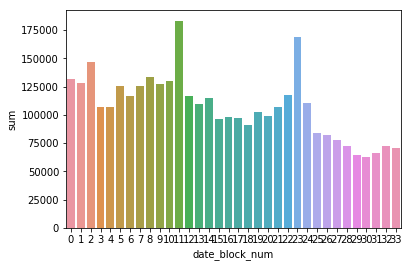

In [5]:
gb = train.groupby(by=['date_block_num'], as_index=False).agg({ 'item_cnt_day': ['sum']})
sns.barplot(x=gb['date_block_num'], y=gb['item_cnt_day']['sum'])

We look at item count per day.  By far the most common (22% of cases) is for there to be zero sales per unique item - unique store combination.

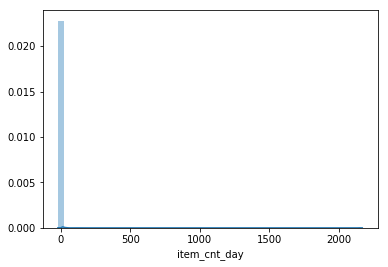

In [6]:
sns.distplot(train['item_cnt_day'])

We next look at the same graph but exclude the zero values.  We now can see how rapidly the sales pattern diminishes.  It looks like a very steep negative exponential distribution.

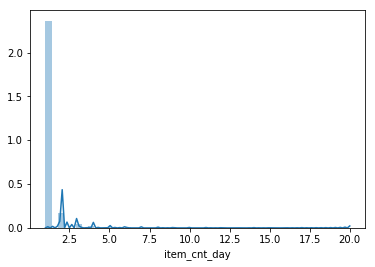

In [7]:
sns.distplot( train[ train['item_cnt_day'] > 0 ]['item_cnt_day'].clip(0, 20) )

Here we employ the gb data frame again as a temporary data frame to create aggregation variables into different buckets depending upon the grouping.

The first group creates a target column.  The next block creates a target_item variable.  A target shop, target category, target price mean and a target price max variabes are all created from this cell.

In [8]:
gb = train.groupby(by=groupby_cols, as_index=False).agg({ 'item_cnt_day': ['sum']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target'}, inplace=True)
df = pd.merge(df, gb, how='left', on=groupby_cols)

gb = train.groupby(by=['date_block_num', 'item_id'], as_index=False).agg({'item_cnt_day':['sum']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target_item'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'item_id'])

gb = train.groupby(by=['date_block_num', 'shop_id'], as_index=False).agg({'item_cnt_day':['sum']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target_shop'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'shop_id'])

gb = train.groupby( by=['date_block_num', 'cat'], as_index=False).agg({ 'item_cnt_day': ['sum'] })
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_cnt_day_sum':'target_cat'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'cat'])

gb = train.groupby(by=['date_block_num', 'item_id'], as_index=False).agg({'item_price':['mean', 'max']})
gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values]
gb.rename(columns={'item_price_mean':'target_price_mean', 'item_price_max':'target_price_max'}, inplace=True)
df = pd.merge(df, gb, how='left', on=['date_block_num', 'item_id'])

We now recode the target price mean and max using the minimum of the actual mean and the 99th %ile of that distribution.  This should take out any extreme outliers.

We fill NA's as zeroes.  We also truncate the target variable to between the range of 0 and 20.  We create a binary variable of 0 if the target variable had been 0 or less and a 1 if it had been above 0.

In [9]:
df['target_price_mean'] = np.minimum(df['target_price_mean'], df['target_price_mean'].quantile(0.99))
df['target_price_max'] = np.minimum(df['target_price_max'], df['target_price_max'].quantile(0.99))

df.fillna(0, inplace=True)
df['target'] = df['target'].clip(0, 20)
df['target_zero'] = (df['target'] > 0).astype("int32")

C:\Users\johnn\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in minimum
  """Entry point for launching an IPython kernel.
C:\Users\johnn\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in minimum
  


We encode a price mean variable using the quantile function again to mimimize the disruption of outliers.

In [10]:
df['target_price_mean2'] = np.minimum(df['target_price_mean'], df['target_price_mean'].quantile(0.99))

We compare the price between this target price 2 variable and the previous mean variabe.  We checkout the first 20.

In [11]:
df['target_price_mean2']-df['target_price_mean'].head(20)

0           0.0
1           0.0
2           0.0
3           0.0
4           0.0
5           0.0
6           0.0
7           0.0
8           0.0
9           0.0
10          0.0
11          0.0
12          0.0
13          0.0
14          0.0
15          0.0
16          0.0
17          0.0
18          0.0
19          0.0
20          NaN
21          NaN
22          NaN
23          NaN
24          NaN
25          NaN
26          NaN
27          NaN
28          NaN
29          NaN
           ... 
11128020    NaN
11128021    NaN
11128022    NaN
11128023    NaN
11128024    NaN
11128025    NaN
11128026    NaN
11128027    NaN
11128028    NaN
11128029    NaN
11128030    NaN
11128031    NaN
11128032    NaN
11128033    NaN
11128034    NaN
11128035    NaN
11128036    NaN
11128037    NaN
11128038    NaN
11128039    NaN
11128040    NaN
11128041    NaN
11128042    NaN
11128043    NaN
11128044    NaN
11128045    NaN
11128046    NaN
11128047    NaN
11128048    NaN
11128049    NaN
Length: 11128050, dtype:

We take a look at the target price mean directly.

In [12]:
df['target_price_mean'].head(20)

0      999.000000
1      899.000000
2     1709.050000
3     1098.850000
4      327.600000
5      549.000000
6      284.333333
7      299.000000
8      392.986538
9      254.200000
10     285.200000
11     261.896552
12    1613.875000
13    1708.950000
14     299.000000
15     286.254167
16    1649.000000
17    1699.000000
18     882.031250
19     145.562500
Name: target_price_mean, dtype: float64

This section does some mean encoding.

First, new columns are made.  enc_shop_id_cat, enc_max_shop_id_cat, enc_shop_id_item_id, enc_max_shop_id_item_id, enc_shop_id, enc_max_shop_id, enc_item_id, enc_max_item_id.  These new columns are initially filled with NaN.

The last portion loops through and fills the newly-created columns with the mean values in the case of the mean columns and the max values in the case of the max columns.

In [13]:
%%time
for enc_cols in [['shop_id', 'cat'], ['shop_id', 'item_id'], ['shop_id'], ['item_id']]:
    
    col = '_'.join(['enc', *enc_cols])
    col2 = '_'.join(['enc_max', *enc_cols])
    df[col] = np.nan
    df[col2] = np.nan
    
    print(col, col2)
    
    for d in tqdm_notebook(df.date_block_num.unique()):
        

        f1 = df.date_block_num < d
        f2 = df.date_block_num == d

        gb = df.loc[f1].groupby(enc_cols)[['target']].mean().reset_index()
        enc = df.loc[f2][enc_cols].merge(gb, on=enc_cols, how='left' )[['target']].copy()
        enc.set_index(df.loc[f2].index, inplace=True)
        df.loc[f2, col] = enc['target']
        
        gb = df.loc[f1].groupby(enc_cols)[['target']].max().reset_index()
        enc = df.loc[f2][enc_cols].merge(gb, on=enc_cols, how='left' )[['target']].copy()
        enc.set_index(df.loc[f2].index, inplace=True)
        df.loc[f2, col2] = enc['target']

enc_shop_id_cat enc_max_shop_id_cat


HBox(children=(IntProgress(value=0, max=35), HTML(value='')))


enc_shop_id_item_id enc_max_shop_id_item_id


HBox(children=(IntProgress(value=0, max=35), HTML(value='')))


enc_shop_id enc_max_shop_id


HBox(children=(IntProgress(value=0, max=35), HTML(value='')))


enc_item_id enc_max_item_id


HBox(children=(IntProgress(value=0, max=35), HTML(value='')))


Wall time: 5min 52s


This part reduces the memory allocation of each of the columns of the dataframe to allow for faster processing.

In [14]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float32_cols = [c for c in df if df[c].dtype == "float64"]
    int32_cols = [c for c in df if df[c].dtype in ["int64", "int16", "int8"] ]
            
    # Downcast
    df[float32_cols] = df[float32_cols].astype(np.float32)
    df[int32_cols]   = df[int32_cols].astype(np.int32)
        
    return df

Here we replace na values with 0.  We then downcast these columns as well.

In [15]:
df.fillna(0, inplace=True)
df = downcast_dtypes(df)

More modules and packages are imported and new groupby columns are created as well as shift ranges.  These will be used next block.

In [16]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import gc
from time import sleep

groupby_cols = ['date_block_num', 'shop_id', 'item_id']
shift_range = [1, 2, 3, 4, 5, 12]

Here, new lag variables are created.  They are shifted by 1, 2, 3, 4, 5, and 12 months.  These are merged into the data frame to create more features.  The naming convention is created in the lambda function as "x_lag_shift#", where the x values come from the shifted columns, which is all the target columns and where the shift values come from the shift range (1-5, 12). 

At the bottom, the newly absorbed filled columns are merged onto the data frame, the now-unneeded shifted columns list is deleted, garbage is collected to free up memory ("gc.collect()), and python sleeps for 1 second ("sleep(1)").

In [17]:
%%time

shifted_columns = [c for c in df if 'target' in c]
print(shifted_columns)


for shift in tqdm_notebook(shift_range):
    
    
    shifted_data = df[groupby_cols + shifted_columns].copy()
    shifted_data['date_block_num'] = shifted_data['date_block_num'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in shifted_columns else x
    shifted_data = shifted_data.rename(columns=foo)
    
    
    df = pd.merge(df, shifted_data, how='left', on=groupby_cols).fillna(0)
    df = downcast_dtypes(df)

    del shifted_data
    gc.collect()
    sleep(1)

['target', 'target_item', 'target_shop', 'target_cat', 'target_price_mean', 'target_price_max', 'target_zero', 'target_price_mean2']


HBox(children=(IntProgress(value=0, max=6), HTML(value='')))


Wall time: 1min 48s


Here we create trend and prediction variables for different time amounts.  First (y(2)|t+1), then (y(4)|t+3), etc.  We create these at the target, target_item, and target_shop levels.

In [18]:
df['target_trend_1_2'] = df['target_lag_1'] - df['target_lag_2']
df['target_predict_1_2'] = df['target_lag_1']*2 - df['target_lag_2']

df['target_trend_3_4'] = df['target_lag_1'] + df['target_lag_2'] - df['target_lag_3'] - df['target_lag_4']
df['target_predict_3_4'] = (df['target_lag_1'] + df['target_lag_2'])*2 - df['target_lag_3'] - df['target_lag_4']

df['target_item_trend_1_2'] = df['target_item_lag_1'] - df['target_item_lag_2']
df['target_item_trend_3_4'] = df['target_item_lag_1'] + df['target_item_lag_2'] - df['target_item_lag_3'] - df['target_item_lag_4']
df['target_shop_trend_1_2'] = df['target_shop_lag_1'] - df['target_shop_lag_2']
df['target_shop_trend_3_4'] = df['target_shop_lag_1'] + df['target_shop_lag_2'] - df['target_shop_lag_3'] - df['target_shop_lag_4']

The columns are again downcasted to save memory allocation.  The dataframe is also converted to a bytestream as df.pkl.  This would allow a data scientist to just load the jupyter notebook from this point instead of having to execute all the cells above this one again.

In [19]:
df = downcast_dtypes(df)
df.to_pickle("df.pkl")

Because the code can be run separately in the future from this point, the same modules and packages are imported again here as well as a few we haven't seen yet.

In [20]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, log_loss, accuracy_score, roc_curve, roc_auc_score
import gc
import xgboost as xgb
from sklearn.model_selection import train_test_split
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

The data frame is reloaded (or "unpickled").  The columns are separated into two different types, drop columns and features.  Features will be used after this, and drop columns will not.  The training and test data is relabeled using the f0 and f1 objects.  The training and test data is separated.

In [21]:
df = pd.read_pickle("df.pkl")

drop_columns = [c for c in df if c[-1] not in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0'] and c.startswith('target')]
drop_columns += ['ID']
features = df.columns.difference( drop_columns )

f0 = df.date_block_num < 34
f1 = df.date_block_num == 34

train, val = train_test_split(df[f0], test_size=0.2, stratify=df[f0]['target'])
test = df[f1]

The data frame is deleted here as it will not be used again.  Garbage is collected to free up memory.

In [22]:
del df
gc.collect()

64

The data are separated into three different groups, training, validation, and test.  These are in the xgboost data type, DMatrix.

In [23]:
Train = xgb.DMatrix( train[features], train['target'] )
Val = xgb.DMatrix( val[features], val['target'] )
Test = xgb.DMatrix( test[features])

The Gradient Boosting Machine is trained using the training data with these parameters set.  These parameters were found to be optimal for this training data.

In [24]:
%%time

xgb_params = {'booster': 'gbtree',
          'eta': .1,
          'min_child_weight': 100,
          'max_depth': 6,
          'objective': 'reg:linear',
          'eval_metric': 'rmse',
          'silent': False,
          'nthread': 8}

model = xgb.train(xgb_params, Train, 1000, [(Train, 'Train'), (Val, 'Val')], early_stopping_rounds=10, verbose_eval=1 )

[0]	Train-rmse:1.1886	Val-rmse:1.18921
Multiple eval metrics have been passed: 'Val-rmse' will be used for early stopping.

Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Train-rmse:1.14603	Val-rmse:1.14721
[2]	Train-rmse:1.10984	Val-rmse:1.11155
[3]	Train-rmse:1.07902	Val-rmse:1.08119
[4]	Train-rmse:1.05229	Val-rmse:1.05483
[5]	Train-rmse:1.03063	Val-rmse:1.03343
[6]	Train-rmse:1.0113	Val-rmse:1.01432
[7]	Train-rmse:0.994948	Val-rmse:0.998135
[8]	Train-rmse:0.981314	Val-rmse:0.984711
[9]	Train-rmse:0.969667	Val-rmse:0.973214
[10]	Train-rmse:0.960159	Val-rmse:0.963894
[11]	Train-rmse:0.952029	Val-rmse:0.955874
[12]	Train-rmse:0.94483	Val-rmse:0.948809
[13]	Train-rmse:0.938955	Val-rmse:0.943074
[14]	Train-rmse:0.933703	Val-rmse:0.937964
[15]	Train-rmse:0.929242	Val-rmse:0.933661
[16]	Train-rmse:0.924421	Val-rmse:0.929106
[17]	Train-rmse:0.92094	Val-rmse:0.925765
[18]	Train-rmse:0.917964	Val-rmse:0.922904
[19]	Train-rmse:0.915331	Val-rmse:0.92034
[20]	Train-rmse:0.912971	Val

[187]	Train-rmse:0.835699	Val-rmse:0.847132
[188]	Train-rmse:0.835176	Val-rmse:0.846632
[189]	Train-rmse:0.834868	Val-rmse:0.846351
[190]	Train-rmse:0.83447	Val-rmse:0.845953
[191]	Train-rmse:0.83439	Val-rmse:0.84589
[192]	Train-rmse:0.834236	Val-rmse:0.845762
[193]	Train-rmse:0.834144	Val-rmse:0.845708
[194]	Train-rmse:0.834044	Val-rmse:0.84564
[195]	Train-rmse:0.83358	Val-rmse:0.845143
[196]	Train-rmse:0.833385	Val-rmse:0.844995
[197]	Train-rmse:0.833208	Val-rmse:0.844836
[198]	Train-rmse:0.832945	Val-rmse:0.844594
[199]	Train-rmse:0.832773	Val-rmse:0.844427
[200]	Train-rmse:0.83208	Val-rmse:0.843799
[201]	Train-rmse:0.832	Val-rmse:0.843759
[202]	Train-rmse:0.831889	Val-rmse:0.843666
[203]	Train-rmse:0.831756	Val-rmse:0.843561
[204]	Train-rmse:0.831599	Val-rmse:0.843425
[205]	Train-rmse:0.831501	Val-rmse:0.84334
[206]	Train-rmse:0.831312	Val-rmse:0.843185
[207]	Train-rmse:0.831167	Val-rmse:0.843024
[208]	Train-rmse:0.830896	Val-rmse:0.842777
[209]	Train-rmse:0.830703	Val-rmse:0.84262

[375]	Train-rmse:0.811253	Val-rmse:0.826754
[376]	Train-rmse:0.811199	Val-rmse:0.826734
[377]	Train-rmse:0.811154	Val-rmse:0.826716
[378]	Train-rmse:0.811073	Val-rmse:0.826667
[379]	Train-rmse:0.811012	Val-rmse:0.826625
[380]	Train-rmse:0.810964	Val-rmse:0.82659
[381]	Train-rmse:0.810805	Val-rmse:0.826472
[382]	Train-rmse:0.8106	Val-rmse:0.826256
[383]	Train-rmse:0.810507	Val-rmse:0.826218
[384]	Train-rmse:0.810438	Val-rmse:0.82617
[385]	Train-rmse:0.810361	Val-rmse:0.826108
[386]	Train-rmse:0.810319	Val-rmse:0.826086
[387]	Train-rmse:0.810273	Val-rmse:0.826057
[388]	Train-rmse:0.810192	Val-rmse:0.825989
[389]	Train-rmse:0.810149	Val-rmse:0.825959
[390]	Train-rmse:0.810066	Val-rmse:0.825898
[391]	Train-rmse:0.809873	Val-rmse:0.825734
[392]	Train-rmse:0.809793	Val-rmse:0.825665
[393]	Train-rmse:0.809758	Val-rmse:0.82564
[394]	Train-rmse:0.80968	Val-rmse:0.825574
[395]	Train-rmse:0.809632	Val-rmse:0.825565
[396]	Train-rmse:0.809571	Val-rmse:0.825539
[397]	Train-rmse:0.809521	Val-rmse:0.8

[563]	Train-rmse:0.796917	Val-rmse:0.816102
[564]	Train-rmse:0.796872	Val-rmse:0.816093
[565]	Train-rmse:0.796847	Val-rmse:0.816088
[566]	Train-rmse:0.796825	Val-rmse:0.81608
[567]	Train-rmse:0.796754	Val-rmse:0.816025
[568]	Train-rmse:0.796668	Val-rmse:0.815931
[569]	Train-rmse:0.796646	Val-rmse:0.815929
[570]	Train-rmse:0.796599	Val-rmse:0.81589
[571]	Train-rmse:0.796465	Val-rmse:0.815777
[572]	Train-rmse:0.796438	Val-rmse:0.815761
[573]	Train-rmse:0.796388	Val-rmse:0.815719
[574]	Train-rmse:0.79636	Val-rmse:0.815715
[575]	Train-rmse:0.796312	Val-rmse:0.815673
[576]	Train-rmse:0.796257	Val-rmse:0.815641
[577]	Train-rmse:0.79617	Val-rmse:0.81557
[578]	Train-rmse:0.79613	Val-rmse:0.815552
[579]	Train-rmse:0.796088	Val-rmse:0.81553
[580]	Train-rmse:0.796046	Val-rmse:0.815505
[581]	Train-rmse:0.795961	Val-rmse:0.815426
[582]	Train-rmse:0.795842	Val-rmse:0.815327
[583]	Train-rmse:0.795806	Val-rmse:0.815315
[584]	Train-rmse:0.795663	Val-rmse:0.815157
[585]	Train-rmse:0.795622	Val-rmse:0.81

[751]	Train-rmse:0.786068	Val-rmse:0.808097
[752]	Train-rmse:0.786015	Val-rmse:0.808059
[753]	Train-rmse:0.785938	Val-rmse:0.807988
[754]	Train-rmse:0.785893	Val-rmse:0.807955
[755]	Train-rmse:0.785849	Val-rmse:0.807936
[756]	Train-rmse:0.78582	Val-rmse:0.807916
[757]	Train-rmse:0.785793	Val-rmse:0.807904
[758]	Train-rmse:0.78574	Val-rmse:0.807866
[759]	Train-rmse:0.785724	Val-rmse:0.807867
[760]	Train-rmse:0.785707	Val-rmse:0.807855
[761]	Train-rmse:0.785637	Val-rmse:0.807796
[762]	Train-rmse:0.785624	Val-rmse:0.807792
[763]	Train-rmse:0.785552	Val-rmse:0.807744
[764]	Train-rmse:0.785517	Val-rmse:0.807721
[765]	Train-rmse:0.785468	Val-rmse:0.807682
[766]	Train-rmse:0.785444	Val-rmse:0.807661
[767]	Train-rmse:0.785245	Val-rmse:0.807477
[768]	Train-rmse:0.78518	Val-rmse:0.807434
[769]	Train-rmse:0.785143	Val-rmse:0.807411
[770]	Train-rmse:0.785092	Val-rmse:0.807394
[771]	Train-rmse:0.785063	Val-rmse:0.807382
[772]	Train-rmse:0.785033	Val-rmse:0.807365
[773]	Train-rmse:0.785003	Val-rmse:

[939]	Train-rmse:0.776688	Val-rmse:0.800948
[940]	Train-rmse:0.77666	Val-rmse:0.800939
[941]	Train-rmse:0.776618	Val-rmse:0.800909
[942]	Train-rmse:0.776601	Val-rmse:0.800894
[943]	Train-rmse:0.776551	Val-rmse:0.800859
[944]	Train-rmse:0.776527	Val-rmse:0.800855
[945]	Train-rmse:0.776491	Val-rmse:0.80085
[946]	Train-rmse:0.77646	Val-rmse:0.800845
[947]	Train-rmse:0.776397	Val-rmse:0.800812
[948]	Train-rmse:0.776298	Val-rmse:0.80075
[949]	Train-rmse:0.776238	Val-rmse:0.800697
[950]	Train-rmse:0.776199	Val-rmse:0.800677
[951]	Train-rmse:0.77617	Val-rmse:0.800661
[952]	Train-rmse:0.775906	Val-rmse:0.800441
[953]	Train-rmse:0.77586	Val-rmse:0.800411
[954]	Train-rmse:0.775836	Val-rmse:0.800393
[955]	Train-rmse:0.775806	Val-rmse:0.800393
[956]	Train-rmse:0.775676	Val-rmse:0.800291
[957]	Train-rmse:0.775653	Val-rmse:0.800288
[958]	Train-rmse:0.775622	Val-rmse:0.800266
[959]	Train-rmse:0.775534	Val-rmse:0.800208
[960]	Train-rmse:0.775518	Val-rmse:0.80021
[961]	Train-rmse:0.775512	Val-rmse:0.80

We predict how many items per month will be sold (from sklearn) but truncate the values to only up to 20.  We also create a csv file called boost_pred to show our predictors.

In [25]:
test['item_cnt_month'] = model.predict(Test).clip(0, 20)
test[['ID', 'item_cnt_month']].sort_values('ID').to_csv('boost_pred.csv', index=False)

This next cell looks at the importance of each feature in this model.  We plot them, and we see that the target price mean, the category, and the item id are the most important, but there are several important features right after those three.

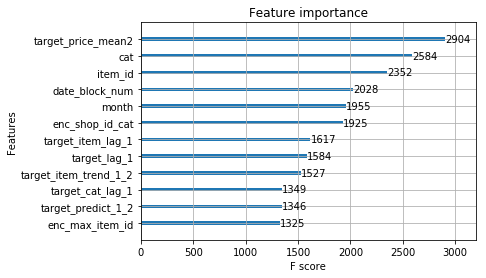

In [26]:
xgb.plot_importance(booster=model, max_num_features=12)

In [27]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pandas as pd
import numpy as np
import gc

This is the identical to the code from two code blocks a few blocks earlier because this is loading the data into the DMatrix data type for xgboost.  This is here again because the model is being loaded from the earlier pickling.

In [ ]:
df = pd.read_pickle("df.pkl")

drop_columns = [c for c in df if c[-1] not in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0'] and c.startswith('target')]
drop_columns += ['item_id', 'shop_id']
drop_columns += ['ID']

features = df.columns.difference( drop_columns )

f0 = df.date_block_num < 34
f1 = df.date_block_num == 34


train, val = train_test_split(df[f0], test_size=0.1, stratify=df[f0]['target'])
test = df[f1]

Train = xgb.DMatrix( train[features], train['target'] )
Val = xgb.DMatrix( val[features], val['target'] )
Test = xgb.DMatrix( test[features])

del df
gc.collect()

Here is an attempt at parameter tuning.  The optimal values are plugged in directly a few code blocks above, but, when starting from scratch, this would be how to find them.

In [ ]:
def objective(params):
    
    params = {
        'booster': 'gbtree',
        'silent': True,
        'nthread': 8,
        
        'eta': "{:.3f}".format(params['eta']),
        'gamma': "{:.3f}".format(params['gamma']),
        'max_depth': int(params['max_depth']),
        'min_child_weight': int(params['min_child_weight']),
        'subsample': "{:.3f}".format(params['subsample']),        
        'colsample_bytree': "{:.3f}".format(params['colsample_bytree']),
        'lambda': "{:.3f}".format(params['lambda']),
        'alpha': "{:.3f}".format(params['alpha']),
          
        'objective': 'reg:linear',
        'eval_metric': 'rmse'
        
    }

    watchlist = [(Train, 'Train'), (Val, 'Val')]
    
    model = xgb.train(
        params,
        Train,
        25,
        evals=watchlist,
        early_stopping_rounds=10,
        verbose_eval=100 )
    
    

    y_pred = model.predict(Val)
    score = np.sqrt( mean_squared_error(val['target'].clip(0, 20), y_pred.clip(0, 20)))
    
    #score = 1
                    
    print("score {:.3f} params {}".format(score, params))
    return score

space = {
    'eta': hp.uniform('learning_rate', 0.01, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),'gamma': hp.uniform('gamma', 0.0, 0.3),
    'max_depth': hp.quniform('max_depth', 2, 12, 1),
    'min_child_weight': hp.uniform('min_child_weight', 1, 200),
    'subsample': hp.uniform('subsample', 0.5, 1.0),    
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'lambda': hp.uniform('lambda', 0.0, 0.3),
    'alpha': hp.uniform('alpha', 0.0, 0.3),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=3)

print(best)